In [1]:
import pandas as pd
import datajoint as dj
dj.config['database.host'] = '10.86.1.219'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'retina'
dj.config["enable_python_native_blobs"] = True # Only for testing in dj0.12 (https://github.com/datajoint/datajoint-python#python-native-blobs)

%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE

import main
import seaborn as sns
drive_path = r"\\NERFHF01/djnerf1/VEIDB/"
# data_path = r"Y:\Data"
data_path =r"W:\Data/"
ft = main.load(drive_path, data_path)

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@10.86.1.219:3306


In [2]:
from datetime import date
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
import os
import seaborn as sb
sb.set_style('white')

In [3]:
from ephys.readSGLX import readMeta, SampRate, makeMemMapRaw,GainCorrectIM, ChannelCountsNI, GainCorrectNI

In [4]:
exp_table = ft.Experiment()
sess_table = ft.Session()
mouse_table = ft.Mouse()
subsess_table = ft.Subsession()
raw_table = ft.ephys_tables.EphysRaw()
raw_table_helper = ft.ephys_tables.EphysRawHelper()
subsess_events_table = ft.event_tables.SubsessionEvents()
subsess_spikes_table = ft.ephys_tables.SubsessionSpikes()
trial_events_table = ft.event_tables.TrialEvents()

sorted_table = ft.ephys_tables.SpikeSorted()

In [5]:
ap_path = os.path.join(data_path, (raw_table & {'subsession_id': 'OPTS_0001', 'experiment_id': '01232'}).fetch1('ap_path'))

In [6]:
from pathlib import Path

binFullPath = Path(ap_path)

In [7]:
# Other parameters about what data to read
tStart = 24
tEnd = 26
sStart = 730722
sEnd = 732224
dataType = 'A'    # 'A' for analog, 'D' for digital data

# For analog channels: zero-based index of a channel to extract,
# gain correct and plot (plots first channel only)
chanList = list(range(0, 374, 1))

# For a digital channel: zero based index of the digital word in
# the saved file. For imec data there is never more than one digital word.
dw = 0

# Zero-based Line indicies to read from the digital word and plot.
# For 3B2 imec data: the sync pulse is stored in line 6.
dLineList = [0, 1, 6]


In [8]:
# Read in metadata; returns a dictionary with string for values
meta = readMeta(binFullPath)

rawData = makeMemMapRaw(binFullPath, meta)

nChan: 385, nFileSamp: 18355524


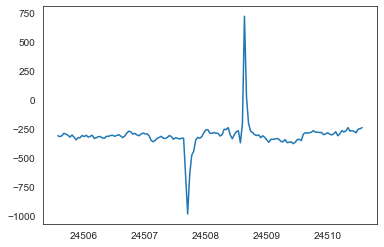

In [319]:
# parameters common to NI and imec data
sRate = SampRate(meta)
# firstSamp = int(sRate*tStart)
# lastSamp = int(sRate*tEnd)
before = 60
# sStart = 18178429-before
# sEnd = 18178459+30
sStart = 735227-before
sEnd = 735257+60

firstSamp = sStart
lastSamp = sEnd

# array of times for plot
tDat = np.arange(firstSamp, lastSamp+1)
tDat = 1000*tDat/sRate      # plot time axis in msec


if dataType == 'A':
    selectData = rawData[chanList, firstSamp:lastSamp+1]
    if meta['typeThis'] == 'imec':
        # apply gain correction and convert to uV
        convData = 1e6*GainCorrectIM(selectData, chanList, meta)
    else:
        MN, MA, XA, DW = ChannelCountsNI(meta)
        # print("NI channel counts: %d, %d, %d, %d" % (MN, MA, XA, DW))
        # apply gain coorection and conver to mV
        convData = 1e3*GainCorrectNI(selectData, chanList, meta)

    # Plot the first of the extracted channels
    fig, ax = plt.subplots()
    ax.plot(tDat, convData[0, :])
    plt.show()

else:
    digArray = ExtractDigital(rawData, firstSamp, lastSamp, dw,
                              dLineList, meta)

    # Plot the first of the extracted channels
    fig, ax = plt.subplots()

    for i in range(0, len(dLineList)):
       ax.plot(tDat, digArray[i, :])
    plt.show()

In [320]:
convData.shape

(374, 151)

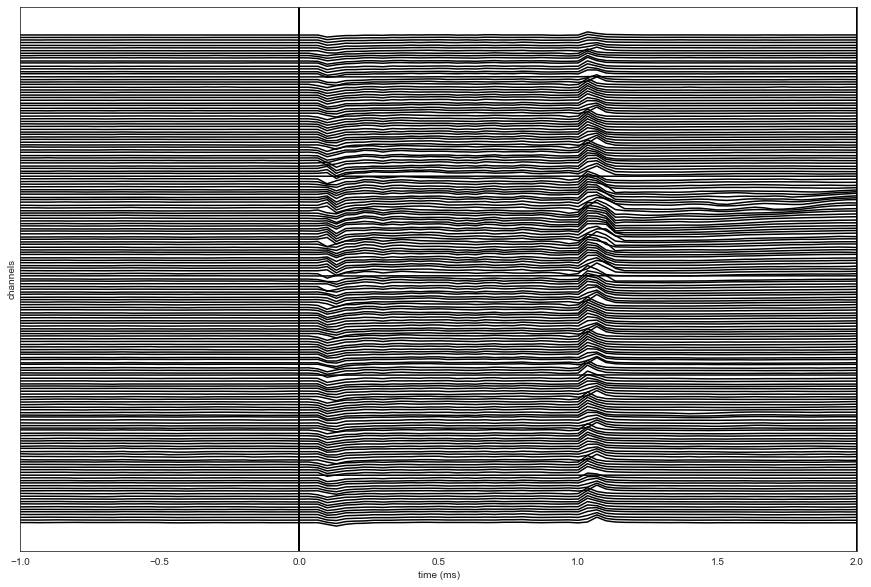

In [321]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for i, row in enumerate(convData[::2,:]):
    ax.plot((np.arange(0, len(row))-before)/30, row+(i*500), 'k')
#     ax.axvline(18178429-(18178429-30*1), c='k', linewidth=2)
    ax.axvline(0, c='k', linewidth=2)
    ax.axvline((lastSamp-30-firstSamp-before)/30, c='k', linewidth=2)
    ax.set(xlabel='time (ms)', ylabel='channels', yticks=[], xlim=[-1, 2])
# plt.savefig('opto_high_sync.png', dpi=150)
plt.show()

In [57]:
sync_trace = (raw_table & {'subsession_id': 'OPTS_0001', 'experiment_id': '01232'}).fetch1('sync_trace')

In [58]:
sync_trace.shape

(16, 18355524)

In [97]:
np.where(np.diff(sync_trace[1]))[0][:40]

array([730722, 730752, 732224, 732254, 733725, 733755, 735227, 735257,
       736729, 736759, 738230, 738260, 739732, 739762, 741234, 741264,
       742735, 742765, 744237, 744267, 745739, 745769, 747240, 747270,
       748742, 748772, 750244, 750274, 751745, 751775, 753247, 753277,
       754748, 754778, 756250, 756280, 757752, 757782, 759253, 759283],
      dtype=int64)

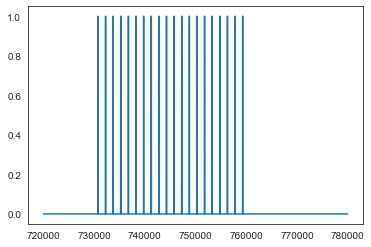

In [78]:
x = np.arange(0, sync_trace.shape[1])
y = sync_trace[1,:].T
plt.plot(x[24*30000:26*30000], y[24*30000:26*30000])
plt.show()

### Plot waveforms

In [231]:
mean_waveforms = np.load(r'W:\Data\01232\neuropixel\20200328a\sorted\000\mean_waveforms.npy')
spike_templates = np.load(r'W:\Data\01232\neuropixel\20200328a\sorted\000\spike_templates.npy')
spike_clusters = np.load(r'W:\Data\01232\neuropixel\20200328a\sorted\000\spike_clusters.npy')
channel_map = np.load(r'W:\Data\01232\neuropixel\20200328a\sorted\000\channel_map.npy')
channel_positions = np.load(r'W:\Data\01232\neuropixel\20200328a\sorted\000\channel_positions.npy')

In [232]:
print(spike_templates.shape)
print(spike_clusters.shape)
print(mean_waveforms.shape)
print(channel_map.shape)
print(channel_positions.shape)

(19567678,)
(19567678,)
(481, 40, 374)
(374,)
(374, 2)


In [234]:
channel_map

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [183]:
spike_times, spike_clusters, cluster_info = (sorted_table & {'subsession_id': 'OPTS_0001', 'experiment_id': '01232'}).fetch1('spike_times', 'spike_clusters', 'cluster_info')

In [ ]:
np.where()

In [355]:
np.unique(spike_templates[spike_clusters==52]) # 4, 203

array([52], dtype=uint32)

In [356]:
mean_waveforms[8].shape

(40, 374)

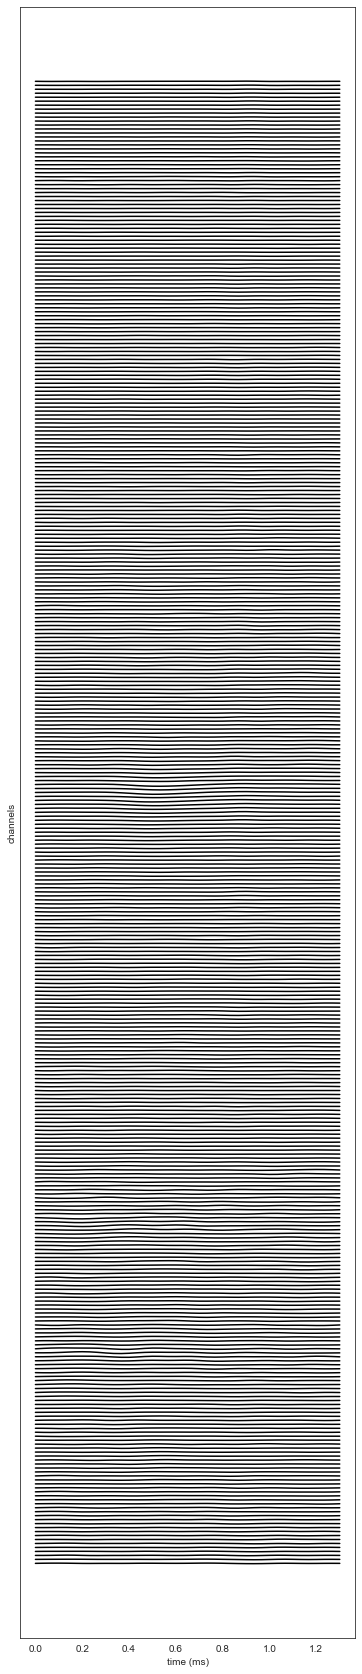

In [362]:
fig, ax = plt.subplots(1, 1, figsize=(6, 30))
for i, row in enumerate(mean_waveforms[203].T): # check 203 -> nothing
    ax.plot((np.arange(0, len(row)))/30, row+(i*500), 'k')
    ax.set(xlabel='time (ms)', ylabel='channels', yticks=[])
plt.savefig('mean_waveform_unit203.png', dpi=150)
plt.show()

### Display waveforms in raw data

In [252]:
trials_starts, trials_ends = (subsess_events_table & {'subsession_id': 'OPTS_0001', 'experiment_id': '01232'}).fetch1('trials_starts', 'trials_ends')

In [279]:
trials_starts[0], trials_ends[0]

(730723, 759254)

In [358]:
unit = 203
firstSamp = 735227-60
lastSamp = 735257+60
channel_window = 6
time_window = 6

""" Find spiketimes of specific unit within timewindow """
unit_spike_times = spike_times[spike_clusters==unit]
unit_spike_times = unit_spike_times[(unit_spike_times-time_window>=firstSamp) & (unit_spike_times+time_window<lastSamp)]

""" Find what channel the unit is most present on """
channel = cluster_info['ch'][unit] # len(channel_map) - cluster_info['ch'][unit]


In [359]:
convData.shape

(374, 151)

In [360]:
unit_spike_times

array([], dtype=uint64)

45.0
150 57.0 45.0
45.0
150 57.0 45.0
45.0
150 57.0 45.0
45.0
150 57.0 45.0
45.0
150 57.0 45.0
45.0
150 57.0 45.0
45.0
150 57.0 45.0
45.0
150 57.0 45.0
45.0
150 57.0 45.0
45.0
150 57.0 45.0
45.0
150 57.0 45.0
45.0
150 57.0 45.0


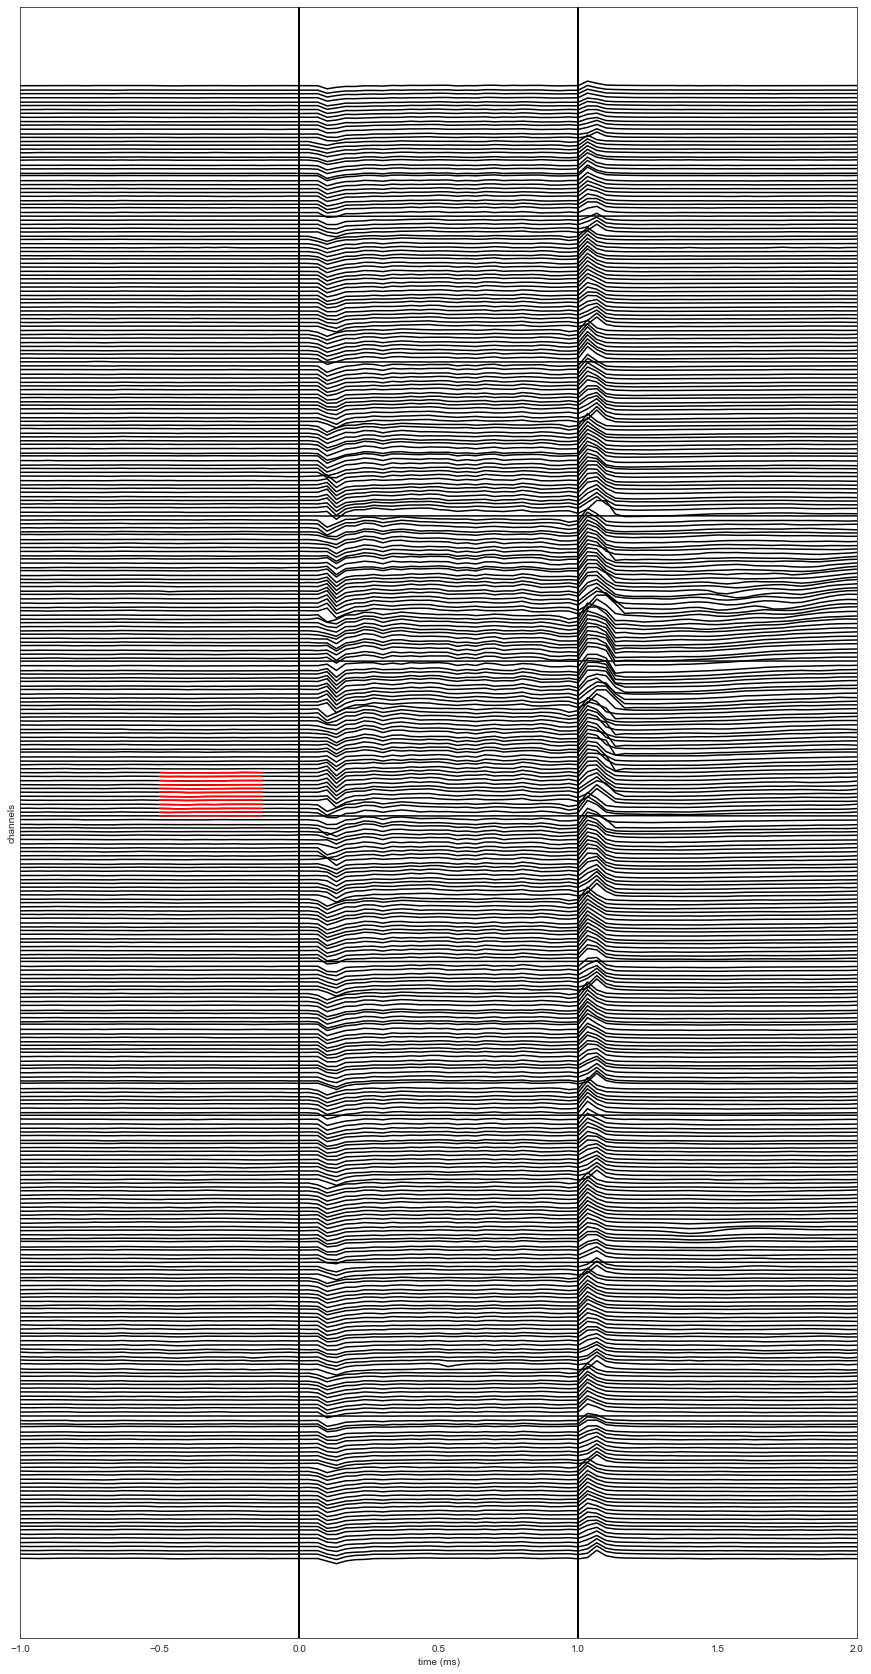

In [354]:
fig, ax = plt.subplots(1, 1, figsize=(15, 30))
for i, row in enumerate(convData[:,:]):
    ax.plot((np.arange(0, len(row))-before)/30, row+(i*500), 'k')
#     ax.axvline(18178429-(18178429-30*1), c='k', linewidth=2)
    ax.axvline(0, c='k', linewidth=2)
    ax.axvline((lastSamp-60-firstSamp-before)/30, c='k', linewidth=2)
    ax.set(xlabel='time (ms)', ylabel='channels', yticks=[], xlim=[-1, 2])

for i in range(channel-channel_window, channel+channel_window, 1):
    for spike_time in unit_spike_times:
        print(spike_time-time_window-firstSamp)
        print(lastSamp-firstSamp, spike_time+time_window-firstSamp, spike_time-time_window-firstSamp)
        ax.plot((np.arange(spike_time-time_window-firstSamp, min(lastSamp-firstSamp+1, (spike_time-firstSamp+time_window)))-before)/30, convData[i,int(spike_time-firstSamp-time_window):int(spike_time-firstSamp+time_window)]+(i*500), 'r')

plt.savefig('opto_high_sync_unit203.png', dpi=150)
plt.show()

In [166]:
spike_times[0]

44

In [165]:
spike_clusters.shape

(19567678,)

In [150]:
len([c for c, a in cluster_info['group'].items() if a=='good'])

260

In [157]:
len(np.unique(spike_templates))

481

In [153]:
spike_clusters.shape

(19567678,)

In [170]:
clusters, cluster_info = (subsess_spikes_table & {'experiment_id': '01232', 'subsession_type': 'OPTS'}).fetch1('clusters', 'cluster_info')